In [1]:
%matplotlib inline 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.model_selection import train_test_split
# not needed in Kaggle, but required in Jupyter

Using TensorFlow backend.


In [2]:
base_image_dir = './diabetic-retinopathy-detection/Train/train'
#convertDir='./diabetic-retinopathy-detection/Train/keras_corp'
#readTrainData(base_image_dir)
# os.path.join will join the base_image_dir path with csv file as given below
retina_df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels.csv'))
# lambda function is writing anonymous function to split given image and taking PatientId
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])
# lambda function is writing anonymous function to get all images which extention is .jpeg
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
# to retrive available images                                                        
retina_df['exists'] = retina_df['path'].map(os.path.exists)

print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
# left eye indicate with 1 Right eye with 0
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
#Converts a class vector (integers) to binary class matrix.
from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))
# to drop images from data set which is not available
retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
retina_df.sample(3)

1427 images found of 35126 total


,image,level,PatientId,path,exists,eye,level_cat
7403,9298_right,4,9298,./diabetic-retinopathy-detection/Train/train\9...,True,0,"[0.0, 0.0, 0.0, 0.0, 1.0]"
7418,9317_left,0,9317,./diabetic-retinopathy-detection/Train/train\9...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
6958,8744_left,1,8744,./diabetic-retinopathy-detection/Train/train\8...,True,1,"[0.0, 1.0, 0.0, 0.0, 0.0]"


In [3]:
retina_final = retina_df[['PatientId', 'level']].drop_duplicates()

In [4]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 512, 512

Y = retina_final['level']
# the data, split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_ids, test_ids = train_test_split(retina_final['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 42,
                                   stratify = retina_final['level'])
x_train= retina_df[retina_df['PatientId'].isin(train_ids)]
x_test = retina_df[retina_df['PatientId'].isin(test_ids)]
print('train', x_train.shape[0], 'validation', x_test.shape[0])


train 1115 validation 400


In [5]:
x_train_img=x_train['image']
x_test_img=x_test['image']
y_train = x_train['level_cat']
y_test = x_test['level_cat']

In [6]:
from PIL import Image, ImageFilter
def storeImagestoGivenPath(path,df,crop_size):
    for index,row in df.iterrows():
        #print(imgdata)
        try:
            if(df['exists'][index]):
                #print(retina_df['path'][retina_df.index[imgdata]])
                img = Image.open(df['path'][index])
                img = img.resize((crop_size,crop_size), Image.ANTIALIAS)  
                if(1==df['level'][index]):
                    subpath = os.path.join(path,'MildDr')
                elif(2==df['level'][index]):
                    subpath = os.path.join(path,'ModerateDr')
                elif(3==df['level'][index]):
                    subpath = os.path.join(path,'SevereDr')
                elif(4==df['level'][index]):
                    subpath = os.path.join(path,'ProliferativeDR')
                else:
                    subpath = os.path.join(path,'NoDR')
                
                img.save(os.path.join(subpath,str( df['image'][index]+'.jpeg')), 'JPEG')
        except KeyboardInterrupt:
                        exit(0)

In [7]:
train_dir = './diabetic-retinopathy-detection/TrainDataset/train'
test_dir='./diabetic-retinopathy-detection/TrainDataset/test'
crop_size=512
# as this images already available commented this code
#storeImagestoGivenPath(train_dir,x_train,crop_size)
#storeImagestoGivenPath(test_dir,x_test,crop_size)

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

img_width, img_height = 150, 150
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='input')

Found 1115 images belonging to 5 classes.


In [9]:
#trainDir='./diabetic-retinopathy-detection/Train/data/validation'

test_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='input')

Found 400 images belonging to 5 classes.


In [13]:
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
epochs = 5
model=Sequential()

model.add(Conv2D(32, kernel_size=(3,3), input_shape = input_shape, activation='relu', kernel_initializer='he_uniform',name='Conv1_b1', padding='same' ))
#model.add(Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform',name='Conv2_b1', padding='same'))


#model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', padding='same', name='Conv3_b2'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', padding='same', name='Conv4_b2'))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', padding='same', name='Conv5_b3'))
#model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', padding='same', name='Conv6_b3'))

#model.add(Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', padding='same', name='Conv7_b4'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', padding='same', name='Conv8_b4'))

#model.add(Dense(256, activation='relu', kernel_initializer='he_uniform', name='Dense1_b5'))
#model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform', name='Dense2_b5'))
model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu', kernel_initializer='he_uniform', name='Dense3_b6'))
model.add(Dense(3, activation='softmax', name='Dense_Output'))

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_b1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
Conv4_b2 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
Conv5_b3 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
Conv8_b4 (Conv2D)            (None, 150, 150, 128)     73856     
_________________________________________________________________
Dense2_b5 (Dense)            (None, 150, 150, 256)     33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 150, 256)     0         
_________________________________________________________________
Dense_Output (Dense)         (None, 150, 150, 3)       771       
Total para

In [15]:
history = model.fit_generator(train_generator,steps_per_epoch=70,epochs=epochs,validation_data=validation_generator,validation_steps=20)
model.save_weights('DiabeticRetinopathy_002.h5')

Epoch 1/5
70/70 [==============================] - 1227s 18s/step - loss: 0.7670 - acc: 0.8656 - val_loss: 0.7568 - val_acc: 0.6175
Epoch 2/5
70/70 [==============================] - 1275s 18s/step - loss: 0.7575 - acc: 0.7252 - val_loss: 0.7559 - val_acc: 0.9250
Epoch 3/5
70/70 [==============================] - 12254s 175s/step - loss: 0.7537 - acc: 0.8146 - val_loss: 0.7558 - val_acc: 0.9430
Epoch 4/5
70/70 [==============================] - 1319s 19s/step - loss: 0.7563 - acc: 0.7762 - val_loss: 0.7556 - val_acc: 0.6531
Epoch 5/5
70/70 [==============================] - 1261s 18s/step - loss: 0.7575 - acc: 0.8102 - val_loss: 0.7555 - val_acc: 0.6831


In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


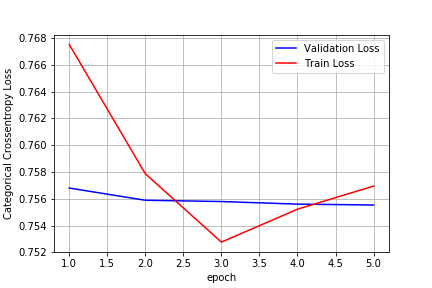

In [17]:
fig,ax = plt.subplots(1,1)
x = list(range(1,epochs+1))
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax) 